In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

### Pooled model

In [4]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sd=1e6)
    obs = pm.Normal('obs', mu, sd=sigma, observed=y)
    
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1846.22draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fc9f630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c23791518>]], dtype=object)

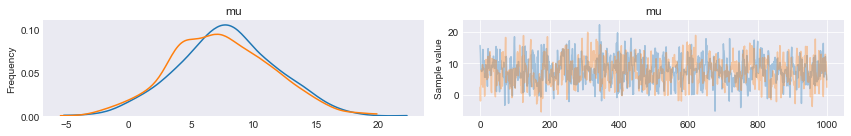

In [5]:
pm.traceplot(trace_p)

### Hierarchical model

In [6]:
with pm.Model() as hierarchical:
    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, sd=1e6)
    tau = pm.HalfCauchy('tau', 5)
    
    theta = pm.Deterministic('theta', mu + tau * eta)
    
    obs = pm.Normal('obs', theta, sd=sigma, observed=y)
    
    trace_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, eta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 913.60draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2430d048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c24411588>]], dtype=object)

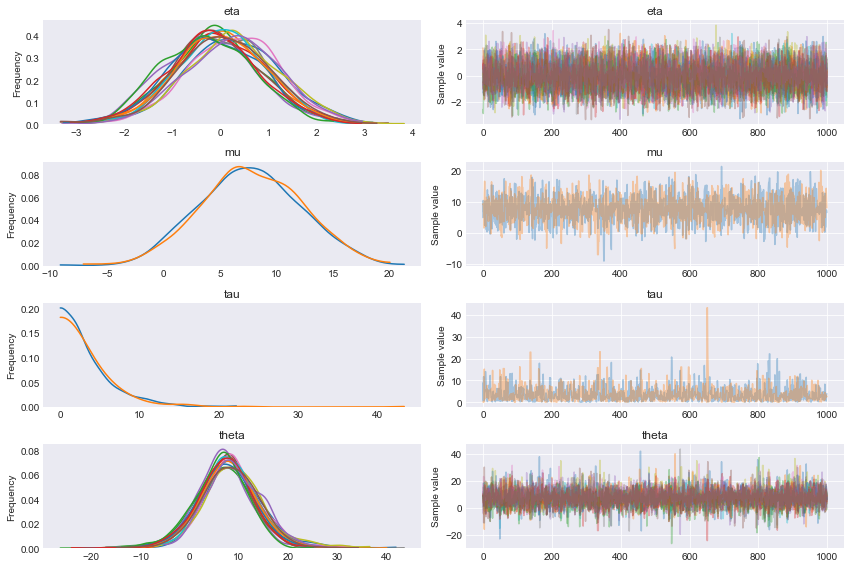

In [7]:
pm.traceplot(trace_h)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24095dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1f92c9b0>]], dtype=object)

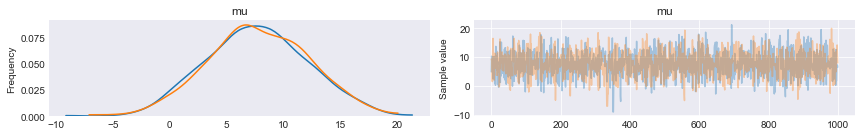

In [8]:
pm.traceplot(trace_h, varnames=['mu'])

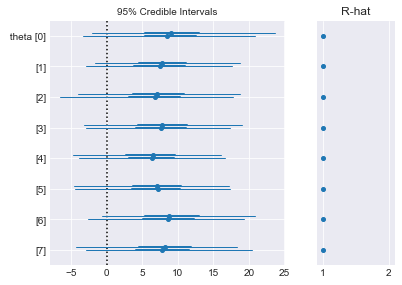

In [9]:
pm.forestplot(trace_h, varnames=['theta'])

### WAIC

In [10]:
pooled_waic = pm.waic(trace_p, pooled)
pooled_waic.WAIC

61.025273496417725

In [11]:
hierarchical_waic = pm.waic(trace_h, hierarchical)
hierarchical_waic.WAIC

61.369564338082427

In [12]:
hierarchical.name = 'hierarchical'
pooled.name = 'pooled'

In [13]:
df_comp_WAIC = pm.compare({hierarchical: trace_h,
                          pooled: trace_p})
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
pooled,61.03,0.63,0,1,2.23,0,0
hierarchical,61.37,0.99,0.34,0,1.99,0.3,0


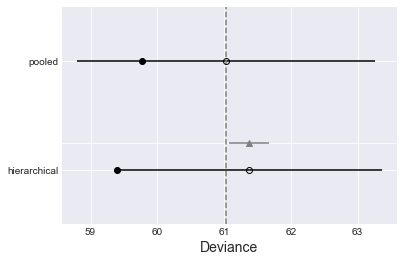

In [14]:
pm.compareplot(df_comp_WAIC)

### Leave-one-out Cross-validation (LOO)

In [15]:
pooled_loo = pm.loo(trace_p, pooled)
pooled_loo.LOO

61.050600153959337

In [16]:
hierarchical_loo = pm.loo(trace_h, hierarchical)
hierarchical_loo.LOO

/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


61.45417362688886

In [17]:
df_comp_LOO = pm.compare({hierarchical: trace_h, pooled: trace_p}, ic='LOO')
df_comp_LOO

/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
pooled,61.05,0.65,0,1,2.23,0,0
hierarchical,61.45,1.03,0.4,0,1.99,0.3,1


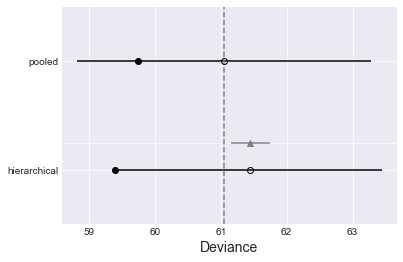

In [18]:
pm.compareplot(df_comp_LOO)